# Recognising vowel sounds using kNN

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from operator import truediv
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

warnings.filterwarnings("ignore")

Before extracting the frequencies using Occenaudio, the data was cleaned and prepared. First I renamed the .wav files with the name of their speakers and removed their parent folder. This was done by the Python script <i>data_preparation.py</i>. Then the csv which would hold the formants was filled with the neccessary features such as word, speaker and gender. This was done by the Python script <i>fill_data.py</i>.

The csv file was then filled manually.

###### Load the formant data

In [2]:
path = os.path.join(os.getcwd(),'..','data','data.csv')
df = pd.read_csv(path)

df

,Speaker,Gender,Word,Phoneme,Class,F1,F2,F3
0,alw001,F,heed,IY1,1,327.272,2963.795,3368.243
1,alw001,F,hid,IH1,2,474.694,2594.058,3326.727
2,alw001,F,head,EH1,3,742.428,2345.833,3132.978
3,cxb001,F,heed,IY1,1,352.846,2825.495,2854.773
4,cxb001,F,hid,IH1,2,360.387,2847.854,3265.437
...,...,...,...,...,...,...,...,...
145,gxb001,M,hid,IH1,2,421.442,2202.315,2723.602
146,gxb001,M,head,EH1,3,567.179,2094.164,2611.026
147,gxi002,M,heed,IY1,1,1144.484,2600.954,3178.739
148,gxi002,M,hid,IH1,2,439.868,2284.849,2744.916


##### The following function splits the training and testing data into 2 seperate groups
Every vowel sound is divided into train and test sets with a 75:25 ratio. Then after every vowel has been processed, the individual train and test sets are joined together respectively.

In [34]:
def train_test():
    x_train = pd.DataFrame(columns=['F1','F2','F3'])
    x_test  = pd.DataFrame(columns=['F1','F2','F3'])
    y_train = pd.DataFrame(columns=['Phoneme'])
    y_test  = pd.DataFrame(columns=['Phoneme'])


    for word in ['heed','hid','head']:
        df_word = df[df['Word'] == word]

        x = df_word.drop(['Speaker','Gender','Word','Phoneme','Class'],axis=1)
        y = df_word[['Phoneme']]

        x_train_tmp,x_test_tmp, y_train_tmp,y_test_tmp = train_test_split(x, y, test_size=0.25)

        x_train = pd.concat([x_train,x_train_tmp])
        x_test  = pd.concat([x_test,x_test_tmp])
        y_train = pd.concat([y_train,y_train_tmp])
        y_test  = pd.concat([y_test,y_test_tmp])

    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    return x_train, x_test, y_train, y_test
    
    

##### We will use kNN (k-Nearest Neighbours) in order to classify unseen formants.
Since the dataset is small and kNN is relatively fast, in orde to get the best value for k, we will enumerate through some list of possible k values. Then we will pick the value of k which produces the least error.

In [12]:
def predict(x_train,x_test,y_train,y_test, max_k=35, metric='minkowski'):
    
    error = []
    
    #Perform kNN for all k in [1:max_k]
    for k in range(1, max_k):
        knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', metric=metric).fit(x_train, y_train)
        prediction = knn.predict(x_test)
        error.append(np.mean(prediction != y_test['Phoneme'])*100)
    
    #Re-perform kNN with the best value of k which will give the least error
    best_k = error.index(min(error))+1
    knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute', metric=metric).fit(x_train, y_train)
    prediction = knn.predict(x_test)   
        
    return prediction

##### We will combine these functions into another function called view_metrics.
This function repeats for num iterations and will generate the training and testing sets, plot the different error rates with all values of k, choose the best value for k and return the average f1_score, recall and precision across all iterations.

<b>This function will generate a new train/test split each time.</b>

In [48]:
def view_metrics(num, df=df, metric='minkowski'):
    
    f1_scores = []
    recalls = []
    precisions = []
    
    
    for i in range(num): 
        x_train = pd.DataFrame(columns=['F1','F2','F3'])
        x_test  = pd.DataFrame(columns=['F1','F2','F3'])
        y_train = pd.DataFrame(columns=['Phoneme'])
        y_test  = pd.DataFrame(columns=['Phoneme'])

        #For all vowels
        for word in ['heed','hid','head']:
            df_word = df[df['Word'] == word]

            x = df_word.drop(['Speaker','Gender','Word','Phoneme','Class'],axis=1)
            y = df_word[['Phoneme']]

            x_train_tmp,x_test_tmp, y_train_tmp,y_test_tmp = train_test_split(x, y, test_size=0.25)

            x_train = pd.concat([x_train,x_train_tmp])
            x_test  = pd.concat([x_test,x_test_tmp])
            y_train = pd.concat([y_train,y_train_tmp])
            y_test  = pd.concat([y_test,y_test_tmp])
        
        
        #Normalise distances
        scaler = StandardScaler()
        scaler.fit(x_train)

        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
        
        #Find best k that gives least error
        error = []
        max_k = 35
        for k in range(1, max_k):
            knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute', metric=metric).fit(x_train, y_train)
            prediction = knn.predict(x_test)
            error.append(np.mean(prediction != y_test['Phoneme'])*100)
        
        
        #PLot graph
        plt.plot(range(1, max_k), error, linestyle='dashed', marker='^',alpha=0.5)

        plt.title(f'Error for kNN')
        plt.xlabel('K')
        plt.ylabel('Error %')
        plt.xticks(range(1, max_k))
        plt.tick_params(axis ='x', rotation = 90)     
        
        
        #Get metrics for that value of k
        best_k = error.index(min(error))+1
        knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute', metric=metric).fit(x_train, y_train)
        y_pred = knn.predict(x_test)

        cf_matrix = confusion_matrix(y_pred, y_test)
        diag = cf_matrix.diagonal()
        
        f1_scores.append(f1_score(y_test, y_pred, average='macro'))
        recalls.append(list(diag/cf_matrix.sum(axis=1)))
        precisions.append(list(map(truediv, diag, np.sum(cf_matrix, axis=0)))    )
        
        
        
    plt.show()
    
    return round(np.mean(f1_scores),2), round(np.mean(recalls),2), round(np.mean(precisions),2)

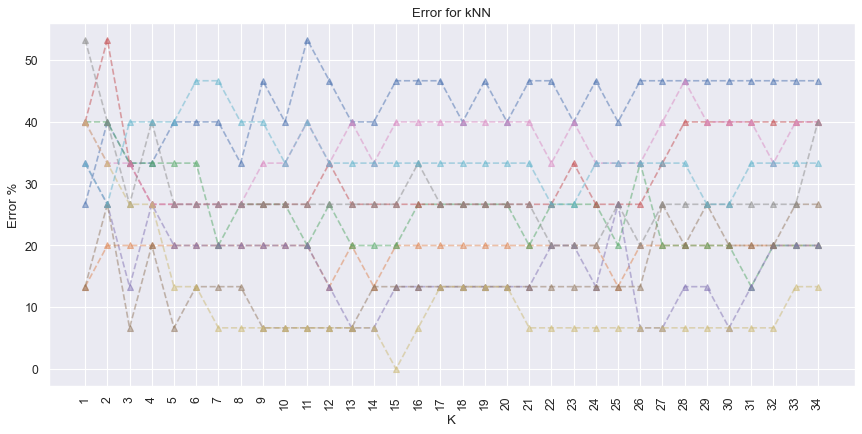

Mean F1, Recall and Precision: 0.83, 0.87, 0.83


In [279]:
plt.figure(figsize=(13, 6), dpi=80)
f1,recall,precision = view_metrics(10,df=df, metric='minkowski')
mean_minimum_error = np.mean(minimum_error)

print(f'Mean F1, Recall and Precision: {f1}, {recall}, {precision}')


### 1. How does performance change with different values of k?
As we can see from the above evaluation, the classifier performs reasobaly well. We can see that across the 10 different iterations, there were many values of k that gave the least error. Some values of k gave an error of 0, while others gave an error of over 50. On average, what are the best values of k?

##### Viewing best values of k across all 10 instances

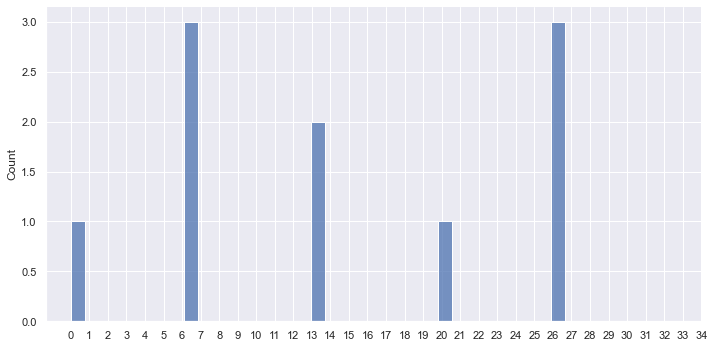

In [280]:
g = sns.displot(minimum_error, bins=35, ax=ax, aspect=2)

plt.xticks(range(0,35,1))
plt.show()


##### From the above histogram, we can see that k=6 and k=26 were picked as the best values of k 3 times.

##### A confusion matrix is used to determine the performance of a classifier.
We can view the confusion matrix as a heat map.

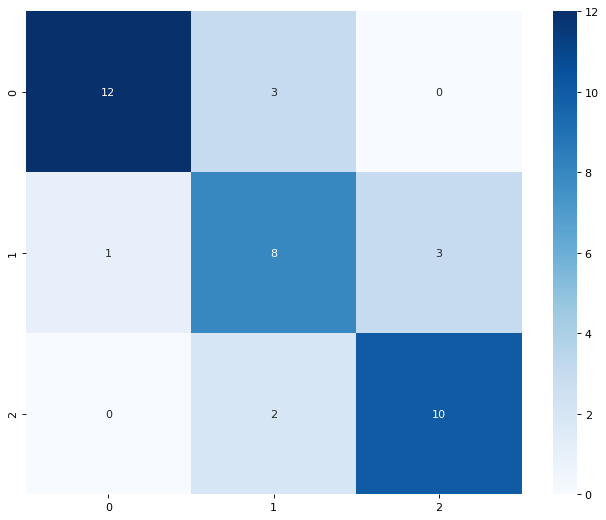

In [39]:
x_train, x_test, y_train, y_test = train_test()
y_pred = predict(x_train, x_test, y_train, y_test)

plt.figure(figsize=(10, 8), dpi=80)

cf_matrix = confusion_matrix(y_pred, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

### 2. Comparing Distance Metrics in kNN. Minkowski vs Euclidian vs Chebyshev vs Manhattan

kNN uses a distance metric in order to match an unseen sample with a known one. There are multiple distance metrics that kNN can use. The default is minkowski distance. We will run each experiment 15 times and take the average metric across those 15 iterations.

In [282]:
num_iterations = 15

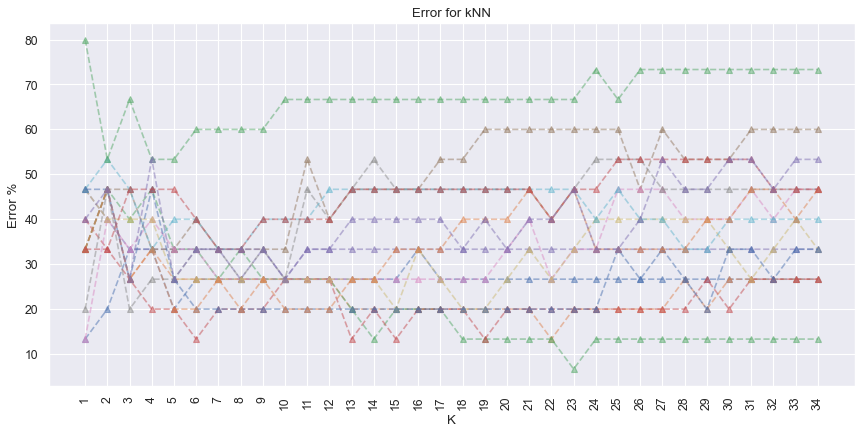

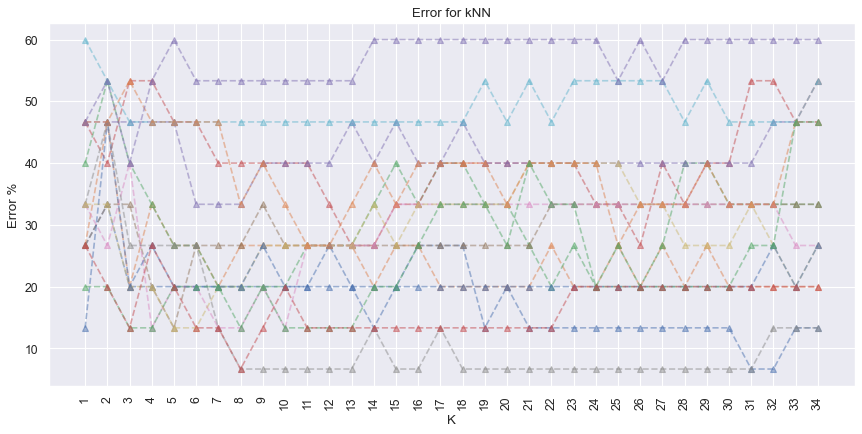

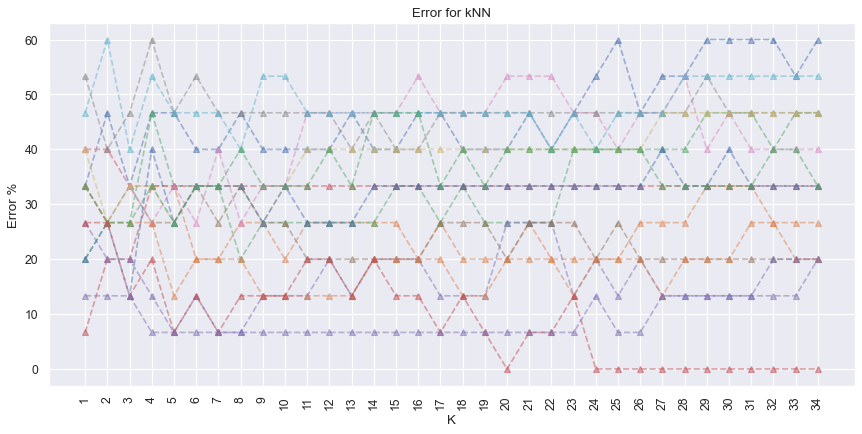

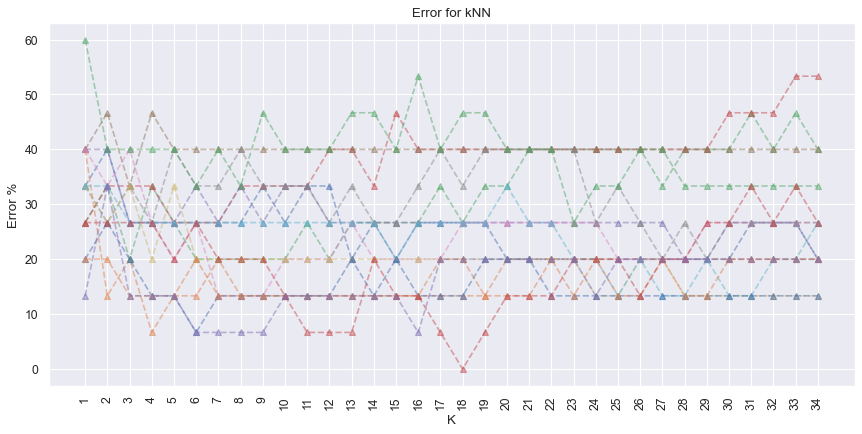

Mean F1, Recall and Precision using Minkowski Distance: 0.76, 0.79, 0.77
Mean F1, Recall and Precision using Euclidean Distance: 0.8, 0.82, 0.8
Mean F1, Recall and Precision using Chebyshev Distance: 0.8, 0.82, 0.8
Mean F1, Recall and Precision using Manhattan Distance: 0.84, 0.86, 0.84


In [283]:
plt.figure(figsize=(13, 6), dpi=80)
f1_minkowski, recall_minkowski, precision_minkowski = view_metrics(num_iterations, metric='minkowski')

plt.figure(figsize=(13, 6), dpi=80)
f1_euclidean, recall_euclidean, precision_euclidean = view_metrics(num_iterations, metric='euclidean')
                                                              
plt.figure(figsize=(13, 6), dpi=80)
f1_chebyshev, recall_chebyshev, precision_chebyshev = view_metrics(num_iterations, metric='chebyshev')

plt.figure(figsize=(13, 6), dpi=80)
f1_manhattan, recall_manhattan, precision_manhattan = view_metrics(num_iterations, metric='manhattan')
                        
print(f'Mean F1, Recall and Precision using Minkowski Distance: {f1_minkowski}, {recall_minkowski}, {precision_minkowski}')
print(f'Mean F1, Recall and Precision using Euclidean Distance: {f1_euclidean}, {recall_euclidean}, {precision_euclidean}')
print(f'Mean F1, Recall and Precision using Chebyshev Distance: {f1_chebyshev}, {recall_chebyshev}, {precision_chebyshev}')
print(f'Mean F1, Recall and Precision using Manhattan Distance: {f1_manhattan}, {recall_manhattan}, {precision_manhattan}')

As we can see from the metrics above, Manhattan distance has best f1_score, recall and precision. Chebyshev and Euclidian distance have the same metrics and the worst one is Minkowski distance.

### 3. Comparing results across different Genders. Male vs Female vs Both.

It is interesting to evaluate the different performances between speakers of different genders. We will split the dataset according to the gender, run the experiment 15 times and compare the average scores.

In [284]:
df_male   = df[df['Gender']=='M']
df_female = df[df['Gender']=='F']

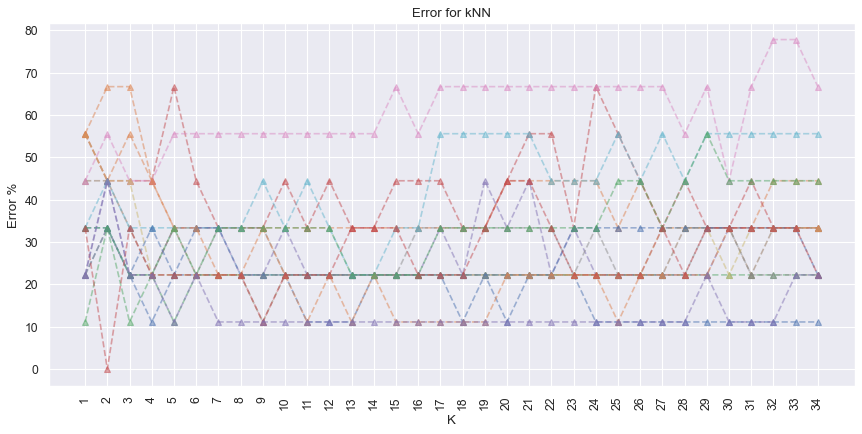

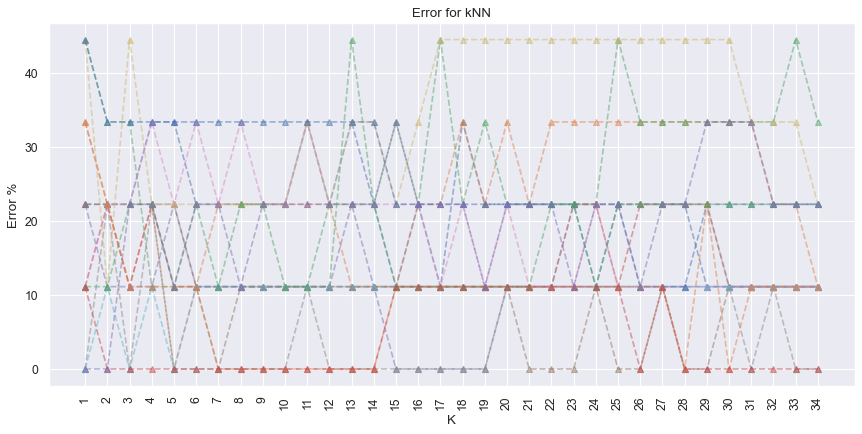

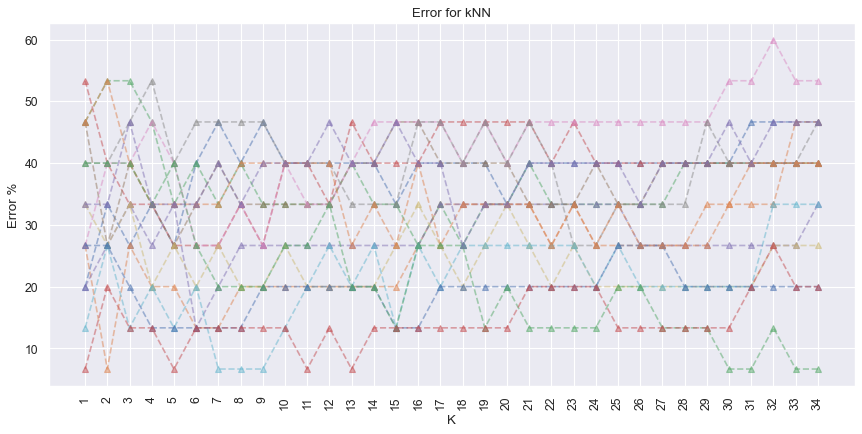

Mean F1, Recall and Precision using Male Voices: 0.79, 0.82, 0.8
Mean F1, Recall and Precision using Female Voices: 0.95, 0.96, 0.95
Mean F1, Recall and Precision using Both Voices: 0.81, 0.83, 0.81


In [286]:
plt.figure(figsize=(13, 6), dpi=80)
f1_male, recall_male, precision_male = view_metrics(num_iterations, df=df_male, metric='manhattan')

plt.figure(figsize=(13, 6), dpi=80)
f1_female, recall_female, precision_female = view_metrics(num_iterations, df=df_female, metric='manhattan')

plt.figure(figsize=(13, 6), dpi=80)
f1_both, recall_both, precision_both = view_metrics(num_iterations, df=df, metric='manhattan')


print(f'Mean F1, Recall and Precision using Male Voices: {f1_male}, {recall_male}, {precision_male}')
print(f'Mean F1, Recall and Precision using Female Voices: {f1_female}, {recall_female}, {precision_female}')
print(f'Mean F1, Recall and Precision using Both Voices: {f1_both}, {recall_both}, {precision_both}')


From the above metrics, it is clear that female voices tend to be the easiest for the classifier to classify. From the female graph (the second one), we can see that there are multiple instances where kNN produced 0% error for some value of k.

### 4. What vowel-based phonemes produce the most confusion?
Using the confusion matrix, we can compute the precision and recall of the classifiers for the different vowels

In [40]:
y_pred = predict(x_train, x_test, y_train, y_test)
cf_matrix = confusion_matrix(y_pred, y_test)

diag = cf_matrix.diagonal()

recall = list(diag/cf_matrix.sum(axis=1))
precision = list(map(truediv, diag, np.sum(cf_matrix, axis=0)))

vowel_metrics = pd.DataFrame([precision, recall], columns = ['Heed (IY1)','Hid (IH1)', 'Head (EH1)'], index=['Precision','Recall'])
vowel_metrics

,Heed (IY1),Hid (IH1),Head (EH1)
Precision,0.923077,0.615385,0.769231
Recall,0.800000,0.666667,0.833333


As we can see, the vowel (IY1) was the easiest for the classifier to classify. The worst vowel was (IH1) with a precision and recall around 66%.